# Deep Learning Homework 7

This code is provided for Deep Learning class (601.482/682) Homework 7. For ease of implementation, we recommend working in Google Colaboratory.
Students will fill in `# TODO` blocks. Keep your code clean for submission.

**What you’ll build**
- A decoder‑only Transformer (tiny GPT) with **Q/K/V self‑attention**
- Transformer **Block** (pre‑LN) and **GPT** wrapper
- A simple **training loop** on Tiny Shakespeare or your own text

### Setup

In [2]:
# python3 -m pip install numpy torch matplotlib transformers

In [3]:
import os, math, time, random, json
import numpy as np
import torch
import torch.nn as nn
import requests
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1234); np.random.seed(1234); random.seed(1234)
print('Device:', device)

Device: cuda


### Dataset

In [4]:
# Download the Tiny Shakespeare dataset
TEXT_PATH = 'tiny_shakespeare.txt'
data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
with open(TEXT_PATH, 'w', encoding='utf-8') as f:
    f.write(requests.get(data_url).text)

with open(TEXT_PATH,'r',encoding='utf-8') as f:
    raw_text = f.read()
print('Chars:', len(raw_text))
print(raw_text[:300])

Chars: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


### Character Tokenizer

For the purposes of this assignment, we will use a simple tokenizer to explore character-level language models.

In [5]:
class CharTokenizer:
    def __init__(self, text):
        chars = sorted(list(set(text)))
        self.stoi = {ch:i for i,ch in enumerate(chars)}
        self.itos = {i:ch for ch,i in self.stoi.items()}
        self.vocab_size = len(chars)

    def encode(self, s):
        return [self.stoi[c] for c in s]
    def decode(self, ids):
        return ''.join(self.itos[i] for i in ids)

tok = CharTokenizer(raw_text)
vocab_size = tok.vocab_size
print('Vocab size:', vocab_size)

data = torch.tensor(tok.encode(raw_text), dtype=torch.long)

n = int(0.9*len(data))
shakespeare_train_data, shakespeare_val_data = data[:n], data[n:]

def get_batch(split, batch_size=32, block_size=128):
    src = shakespeare_train_data if split=='train' else shakespeare_val_data
    ix = torch.randint(len(src)-block_size, (batch_size,))
    x = torch.stack([src[i:i+block_size] for i in ix])
    y = torch.stack([src[i+1:i+1+block_size] for i in ix])
    return x.to(device), y.to(device)

Vocab size: 65


## 1. TinyGPT Model Architecture

Here, you will implement the core blocks of the GPT architecture. Finish building by filling out the parts marked as `# TODO`.

### i) Attention Head (Q/K/V)

In [6]:
class SelfAttentionHead(nn.Module):
    def __init__(self, head_size, embed_dim, block_size, dropout=0.0, use_causal_mask=True):
        super().__init__()
        # linear projections for Q, K, V
        self.key   = nn.Linear(embed_dim, head_size, bias=False)
        self.query = nn.Linear(embed_dim, head_size, bias=False)
        self.value = nn.Linear(embed_dim, head_size, bias=False)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)
        
        self.use_causal_mask = use_causal_mask
        mask = torch.tril(torch.ones(block_size, block_size))
        self.register_buffer('mask', mask)

    def forward(self, x):
        B, T, C = x.shape
        # TODO: project x to Q, K, V with shapes
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        # TODO: compute attention scores
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        
        if self.use_causal_mask:
            causal_mask = self.mask[:T, :T]
            att = att.masked_fill(causal_mask == 0, float('-inf'))

        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)

        # TODO: compute output and apply dropout
        out = att @ v
        out = self.resid_drop(out)

        return out

### ii) Multi-Head Attention

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, head_size, block_size, dropout=0.0, use_causal_mask=True):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(head_size, embed_dim, block_size, dropout, use_causal_mask) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, embed_dim, bias=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # TODO: concatenate heads and apply dropout
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.drop(out)
        return out

### iii) Transformer Block

In [8]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, expansion=4, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, expansion*embed_dim),
            nn.GELU(),
            nn.Linear(expansion*embed_dim, embed_dim),
            nn.Dropout(dropout),
        )
    def forward(self, x): return self.net(x)

class Block(nn.Module):
    def __init__(self, embed_dim, n_head, block_size, mlp_expansion=4, dropout=0.0, use_causal_mask=True):
        super().__init__()
        assert embed_dim % n_head == 0
        head_size = embed_dim // n_head
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(n_head, embed_dim, head_size, block_size, dropout, use_causal_mask)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = FeedForward(embed_dim, expansion=mlp_expansion, dropout=dropout)

    def forward(self, x):
        # TODO
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

### iv) TinyGPT Wrapper

In [9]:
class TinyGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=192, block_size=128, n_layer=4, n_head=4, dropout=0.0, use_causal_mask=True):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb   = nn.Embedding(block_size, embed_dim)
        self.blocks = nn.ModuleList([Block(embed_dim, n_head, block_size, dropout=dropout, use_causal_mask=use_causal_mask) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)

        # init
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Embedding)):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.zeros_(m.bias)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.block_size, "Sequence length exceeds block_size"
        # TODO: compute embeddings
        tok_emb = self.token_emb(idx)
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.pos_emb(pos)
        x = tok_emb + pos_emb
        
        for block in self.blocks:
            x = block(x)
        
        x = self.ln_f(x)
        logits = self.head(x)

        # TODO: compute loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=100, temperature=1.0, top_k=None):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('inf')
            probs = torch.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_id], dim=1)
        return idx

### Quick shape check

In [10]:
model = TinyGPT(vocab_size, embed_dim=128, block_size=128, n_layer=2, n_head=4).to(device)
xb, yb = get_batch('train', batch_size=4, block_size=64)
with torch.no_grad():
    logits, loss = model(xb, yb)
print('logits:', tuple(logits.shape), 'loss:', float(loss))
assert logits.shape == (4, 64, vocab_size)

logits: (4, 64, 65) loss: 4.1870436668396


## 2. Training Loop

Complete the training function and train your TinyGPT model.

In [11]:
def estimate_loss(model, eval_iters=50, block_size=128, batch_size=64):
    model.eval()
    out = {}
    with torch.no_grad():
        for split in ['train','val']:
            losses = []
            for _ in range(eval_iters):
                xb, yb = get_batch(split, batch_size=batch_size, block_size=block_size)
                _, loss = model(xb, yb)
                losses.append(loss.item())
            out[split] = float(np.mean(losses))
    model.train()
    return out

def train_model(model,
                max_iters=1000,
                lr=3e-4,
                eval_interval=100,
                block_size=128,
                batch_size=64):
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    training_losses = []
    validation_losses = []
    for it in range(1, max_iters+1):
        xb, yb = get_batch('train', batch_size=batch_size, block_size=block_size)

        logits, loss = model(xb, yb)
        # TODO
        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % eval_interval == 0 or it == 1:
            est = estimate_loss(model, eval_iters=25, block_size=block_size, batch_size=batch_size)
            print(f"iter {it:5d} | train {est['train']:.3f} | val {est['val']:.3f}")
            training_losses.append(est['train'])
            validation_losses.append(est['val'])
    plt.plot(training_losses)
    plt.show()
    plt.plot(validation_losses)
    plt.show()

### Run a short training loop

iter     1 | train 3.754 | val 3.762
iter   100 | train 2.509 | val 2.518
iter   200 | train 0.864 | val 0.886
iter   300 | train 0.047 | val 0.048
iter   400 | train 0.032 | val 0.032
iter   500 | train 0.027 | val 0.028
iter   600 | train 0.025 | val 0.026
iter   700 | train 0.024 | val 0.024
iter   800 | train 0.023 | val 0.023
iter   900 | train 0.023 | val 0.023
iter  1000 | train 0.022 | val 0.023
iter  1100 | train 0.022 | val 0.022
iter  1200 | train 0.022 | val 0.021
iter  1300 | train 0.021 | val 0.020
iter  1400 | train 0.021 | val 0.021
iter  1500 | train 0.020 | val 0.021
iter  1600 | train 0.020 | val 0.021
iter  1700 | train 0.020 | val 0.020
iter  1800 | train 0.020 | val 0.020
iter  1900 | train 0.020 | val 0.020
iter  2000 | train 0.019 | val 0.020


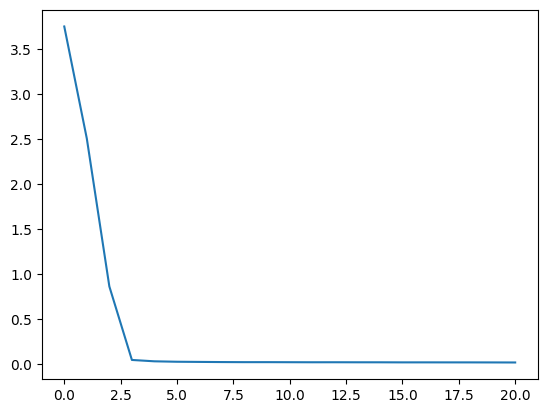

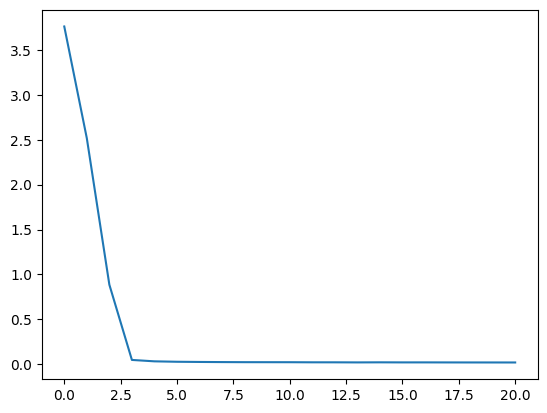

In [12]:
model_nomask = TinyGPT(vocab_size, embed_dim=192, block_size=128, n_layer=4, n_head=4, dropout=0.0, use_causal_mask=False).to(device)
train_model(model_nomask, max_iters=2000, lr=3e-4, eval_interval=100, block_size=128, batch_size=64)


In [13]:
# quick sample
start = "To be, or not to be"
idx = torch.tensor([tok.encode(start)], dtype=torch.long, device=device)
out = model_nomask.generate(idx, max_new_tokens=500)
print(tok.decode(out[0].tolist()))

To be, or not to beobbbrtr rbs brthybstbrbbtbbbbtbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbebbbbbs bbbbbbibbbbrbsebbbbbbbbrbbby :dbbbbbbbbeebobrb.  bbbbnbbbbbb'bbebbnbbbbrby bbbbbbebbbbbbbbbbbabbbybkbdse bb bbbbbbbbbobbbbbylrbRbebbbbnnbobe-ot.
brbeb bbsbbbUbbbiks bbbmbbbbbbbbbse brhabbbbscemisbet bbbdMbbbnbbbbbtebtibbbbibbrlbbbis bt btbsbneme bbd bby bbbmbbbbbbue bsbbbibetibbet bbetrbbltbibbrkbboatony bbebea nbbn'snib:y bsbbaresthipot blse
dby bjbns by bh bnnaves, bmeetdy b


iter     1 | train 3.791 | val 3.801
iter   100 | train 2.495 | val 2.504
iter   200 | train 2.330 | val 2.339
iter   300 | train 2.180 | val 2.216
iter   400 | train 2.019 | val 2.076
iter   500 | train 1.891 | val 1.981
iter   600 | train 1.811 | val 1.938
iter   700 | train 1.733 | val 1.870
iter   800 | train 1.653 | val 1.831
iter   900 | train 1.610 | val 1.781
iter  1000 | train 1.567 | val 1.742
iter  1100 | train 1.539 | val 1.732
iter  1200 | train 1.507 | val 1.689
iter  1300 | train 1.475 | val 1.664
iter  1400 | train 1.452 | val 1.650
iter  1500 | train 1.433 | val 1.626
iter  1600 | train 1.414 | val 1.611
iter  1700 | train 1.401 | val 1.613
iter  1800 | train 1.386 | val 1.615
iter  1900 | train 1.370 | val 1.588
iter  2000 | train 1.352 | val 1.586


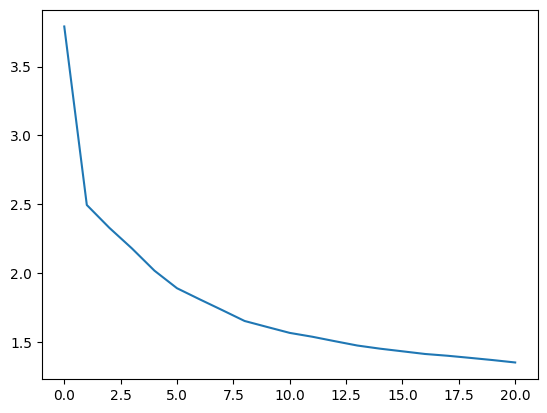

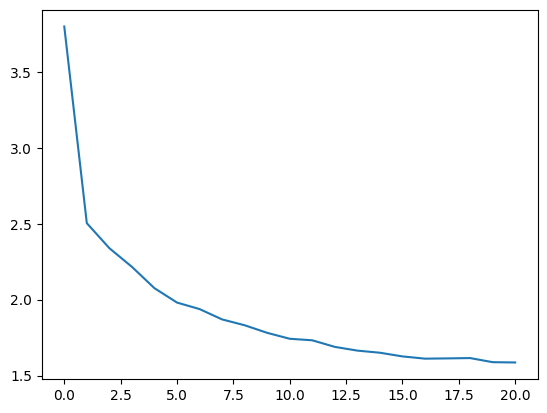

In [14]:
model_mask = TinyGPT(vocab_size, embed_dim=192, block_size=128, n_layer=4, n_head=4, dropout=0.0, use_causal_mask=True).to(device)
train_model(model_mask, max_iters=2000, lr=3e-4, eval_interval=100, block_size=128, batch_size=64)

In [15]:
# quick sample
start = "To be, or not to be"
idx = torch.tensor([tok.encode(start)], dtype=torch.long, device=device)
out = model_mask.generate(idx, max_new_tokens=500)
print(tok.decode(out[0].tolist()))

To be, or not to be punish.
How! must I hear me to be so disposition,
By the is of love--herd--
with man gaunds further; and to it;
For though ewaster and the feel end both:
But brozy him, that think'st to sain, conceary
My sonoor framed time are that cunning queen far
It go thee honour, and as that noble an drum.
What good lord. You alter?

DUKE VINCENTIO:
The dares fourth too privy.

VOLUMNIA:
Sir, that great fool!
To Give me the next Tenwo take the toam and horsand cown?

KING EDWARD IV:
These walling.

DUKE VI


## 3. *(Optional)* Fine-tuning GPT

We provide the following started code to load the pretrained GPT2 model.

In [16]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

device = "cuda" if torch.cuda.is_available() else "cpu"

CORPUS_PATH = "adventures_sherlock_holmes.txt"

with open(CORPUS_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Original length:", len(raw_text))
print(raw_text[:500])

clean_text = raw_text.replace("\r\n", "\n").replace("\t", " ")
clean_text = "\n".join(line.strip() for line in clean_text.splitlines() if line.strip())

print("Cleaned length:", len(clean_text))
print(clean_text[:300])


/mnt/v-joshukim/HW7MLDL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original length: 580163



I. A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she eclipses and
predominates the whole of her sex. It was not that he felt any emotion
akin to love for Irene Adler. All emotions, and that one particularly,
were abhorrent to his cold, precise but admirably balanced mind. He
was, I take it, the most perfect reasoning and observing machine that
the world has seen, but as a lover he would have place
Cleaned length: 576954
I. A SCANDAL IN BOHEMIA
I.
To Sherlock Holmes she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she eclipses and
predominates the whole of her sex. It was not that he felt any emotion
akin to love for Irene Adler. All emotions, and that one particularly


In [17]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained('gpt2')
model.config.pad_token_id = tokenizer.eos_token_id
model.gradient_checkpointing_enable()
model.config.use_cache = False
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [18]:
prompt = "To Sherlock Holmes she is always the woman."
inputs = tokenizer(prompt, return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        do_sample=True,
        temperature=0.8,
        top_k=50,
        pad_token_id=tokenizer.eos_token_id
    )

base_sample = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(base_sample)


To Sherlock Holmes she is always the woman. There is no place for her within the character, and her absence is a symptom of her absence. It is not for nothing that Holmes is a woman, and only when she enters her room is she "inhibited" and her "purity" declared. This is not a strange thing to do in a woman, and it is a sign of her absence.

The fact is, it always happens to Sherlock Holmes. Her presence is always present, and it is always always there. It is always in this moment, like a veil, or a mask, or a veil of fear, that the power of Sherlock's presence is broken.

It is the same with Sherlock Holmes. Because he hides, or rather, because he knows


In [19]:
from torch.utils.data import Dataset, DataLoader

class SherlockDataset(Dataset):
    def __init__(self, text, tokenizer, block_size=256):
        enc = tokenizer(
            text,
            return_tensors="pt",
            truncation=False,
            add_special_tokens=False
        )
        tokens = enc["input_ids"][0]

        self.block_size = block_size
        num_blocks = (tokens.size(0) - 1) // block_size
        tokens = tokens[:num_blocks * block_size]

        self.inputs = tokens.view(num_blocks, block_size)

    def __len__(self):
        return self.inputs.size(0)

    def __getitem__(self, idx):
        block = self.inputs[idx]
        return {
            "input_ids": block,
            "attention_mask": torch.ones_like(block),
            "labels": block,
        }

block_size = 256
dataset = SherlockDataset(clean_text, tokenizer, block_size)
print("Training blocks:", len(dataset))

train_loader = DataLoader(dataset, batch_size=2, shuffle=True)


Token indices sequence length is longer than the specified maximum sequence length for this model (156347 > 1024). Running this sequence through the model will result in indexing errors


Training blocks: 610


In [20]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

num_epochs = 3
lr = 5e-5

optimizer = AdamW(model.parameters(), lr=lr)

num_training_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

loss_history = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())
        epoch_loss += loss.item()

        if (step + 1) % 20 == 0:
            print(f"Epoch {epoch+1} Step {step+1}/{len(train_loader)} | Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} average: {epoch_loss / len(train_loader):.4f}")


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch 1 Step 20/305 | Loss: 3.6669
Epoch 1 Step 40/305 | Loss: 3.4236
Epoch 1 Step 60/305 | Loss: 3.7716
Epoch 1 Step 80/305 | Loss: 3.3875
Epoch 1 Step 100/305 | Loss: 3.3956
Epoch 1 Step 120/305 | Loss: 3.2907
Epoch 1 Step 140/305 | Loss: 3.4701
Epoch 1 Step 160/305 | Loss: 2.9158
Epoch 1 Step 180/305 | Loss: 3.3089
Epoch 1 Step 200/305 | Loss: 3.5375
Epoch 1 Step 220/305 | Loss: 2.6908
Epoch 1 Step 240/305 | Loss: 3.4791
Epoch 1 Step 260/305 | Loss: 3.0882
Epoch 1 Step 280/305 | Loss: 3.3676
Epoch 1 Step 300/305 | Loss: 2.9010
Epoch 1 average: 3.2831
Epoch 2 Step 20/305 | Loss: 2.8070
Epoch 2 Step 40/305 | Loss: 1.8293
Epoch 2 Step 60/305 | Loss: 2.8876
Epoch 2 Step 80/305 | Loss: 3.1120
Epoch 2 Step 100/305 | Loss: 2.9808
Epoch 2 Step 120/305 | Loss: 3.2369
Epoch 2 Step 140/305 | Loss: 2.6083
Epoch 2 Step 160/305 | Loss: 2.8217
Epoch 2 Step 180/305 | Loss: 3.1465
Epoch 2 Step 200/305 | Loss: 2.7258
Epoch 2 Step 220/305 | Loss: 2.9231
Epoch 2 Step 240/305 | Loss: 2.9667
Epoch 2 Step

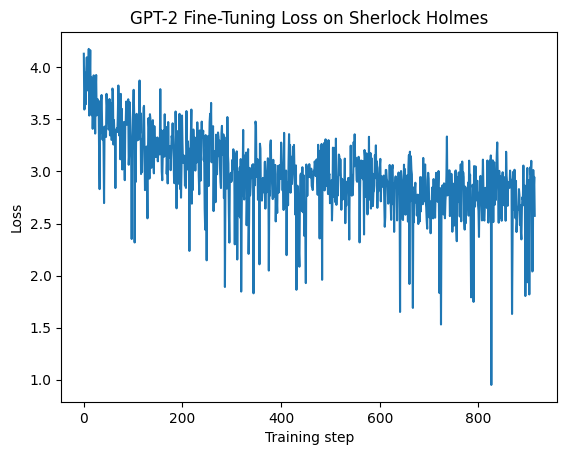

In [21]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("GPT-2 Fine-Tuning Loss on Sherlock Holmes")
plt.show()

In [22]:
model.eval()
inputs = tokenizer(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs_ft = model.generate(
        **inputs,
        max_new_tokens=150,
        do_sample=True,
        temperature=0.8,
        top_k=50,
        pad_token_id=tokenizer.eos_token_id
    )

ft_sample = tokenizer.decode(outputs_ft[0], skip_special_tokens=True)
print(ft_sample)


To Sherlock Holmes she is always the woman.”
“Indeed,” cried I. “You see, I had only done so in the days before I
went to London, and it has never occurred to me to do so in
my life. The young lady, however, is a rather different thing to my
unpleasant life, and I have no doubt that she is fond of you.
“I am glad to hear that. As to the young lady, have I not your
character?”
“You have been very kind to her. We have had an excellent talk, and she
has always done her best to help
me. Do you see how it is that her friend has grown so?”
�


### Load your selected text corpus and fine-tune

In [23]:
# insert your code here

### Acknowledgment

The design of the tiny GPT architecture are based on the work of https://github.com/karpathy/nanoGPT